In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [2]:
data = pd.read_csv("../Data/prepared_data.csv")

In [3]:
data

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,32.625806,23.593548,37.380645,27.251613,2.758065,...,19.784194,4.540323,28.529167,28.526478,28.419355,27.342876,0.390527,0.343621,0.305570,0.424620
9012,MA413,2023,4,2.0,3.0,32.833333,23.786667,37.903333,27.520000,2.563333,...,20.378667,4.632667,28.858889,28.759306,28.444028,27.731250,0.398275,0.348147,0.299015,0.413540
9013,MA413,2023,5,3.0,4.0,32.225806,24.061290,37.435484,28.312903,3.029032,...,18.983226,4.261290,28.559140,28.523656,28.383737,27.991801,0.416329,0.391871,0.301789,0.404790
9014,MA413,2023,6,1.0,1.0,29.463333,22.926667,33.333333,26.320000,6.823333,...,14.725667,3.271000,26.370000,26.618611,27.324167,27.972361,0.454496,0.444658,0.349479,0.399222


In [4]:
data_train = data.drop(data.groupby("FarmID").tail(6).index)
data_test = data.groupby("FarmID").tail(6)

In [5]:
data_train['Date'] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data_train.iterrows()]

In [6]:
data_train["Date"] = pd.to_datetime(data_train["Date"])

In [7]:
data_train

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,Date
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218,1998-01-01
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451,1998-02-01
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526,1998-03-01
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946,1998-04-01
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663,1998-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9005,MA413,2022,9,4.0,45.0,28.063333,21.953333,32.260000,25.243333,7.030000,...,3.079333,24.925417,25.028750,25.308889,26.003333,0.472574,0.477844,0.493833,0.459283,2022-09-01
9006,MA413,2022,10,2.0,37.0,28.629032,22.025806,34.119355,25.803226,4.745161,...,3.326129,25.327688,25.303091,25.308871,25.693817,0.469147,0.471316,0.489003,0.490792,2022-10-01
9007,MA413,2022,11,5.0,17.0,29.446667,21.850000,34.520000,25.436667,1.643333,...,3.656000,25.809722,25.777083,25.705417,25.609167,0.432499,0.431210,0.430129,0.485847,2022-11-01
9008,MA413,2022,12,15.0,10.0,31.241935,21.080645,34.325806,23.629032,0.596774,...,4.183871,26.284946,26.181317,25.946640,25.717876,0.343508,0.352405,0.381405,0.471591,2022-12-01


2. Split the data

In [8]:
def split_data(data, n_splits):
    data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "valid": pd.DataFrame()} for i in range(1, n_splits+1)}

    # Tworzenie TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for farmid in data_train["FarmID"].unique():
        for i, (train_index, test_index) in enumerate(tscv.split(data[data["FarmID"] == farmid]["Date"])):
            train_data = data[data["FarmID"] == farmid].iloc[train_index]
            valid_data = data[data["FarmID"] == farmid].iloc[test_index]

            data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
            data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)
    
    return data_dict

In [9]:
data_dict = split_data(data_train, 5)

C:\Users\BC127735\AppData\Local\Temp\ipykernel_15632\2889282722.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_15632\2889282722.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)


In [170]:
for i in range(1, 6):
    print(f"Iteration {i} - train: ", data_dict[f"iter_{i}"]["train"].shape)
    print(f"Iteration {i} - valid: ", data_dict[f"iter_{i}"]["valid"].shape)

Iteration 1 - train:  (1578, 25)
Iteration 1 - valid:  (1406, 25)
Iteration 2 - train:  (2984, 25)
Iteration 2 - valid:  (1406, 25)
Iteration 3 - train:  (4390, 25)
Iteration 3 - valid:  (1406, 25)
Iteration 4 - train:  (5796, 25)
Iteration 4 - valid:  (1406, 25)
Iteration 5 - train:  (7202, 25)
Iteration 5 - valid:  (1406, 25)


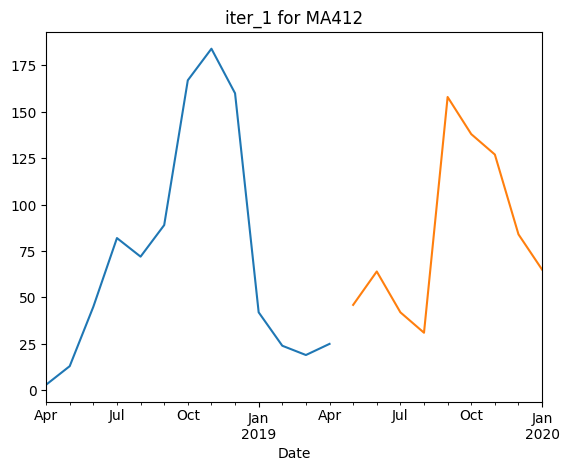

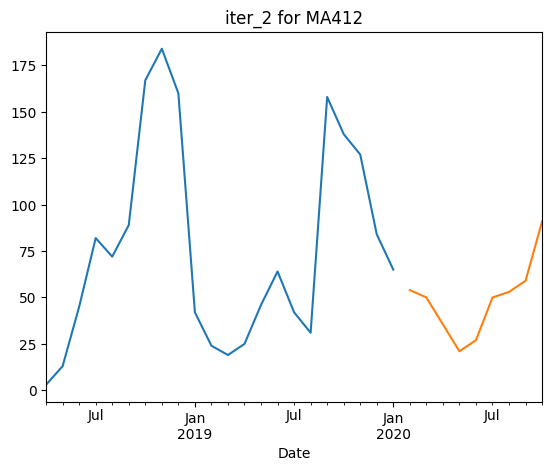

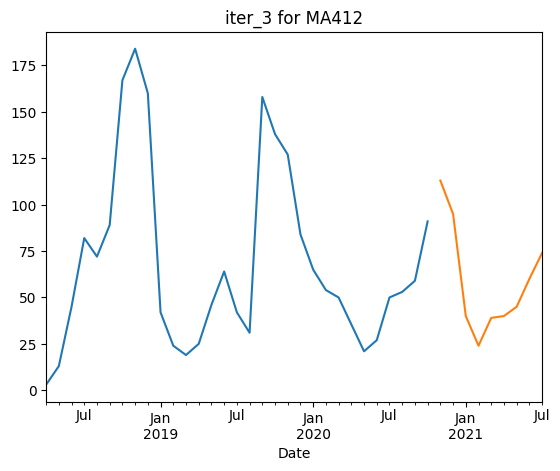

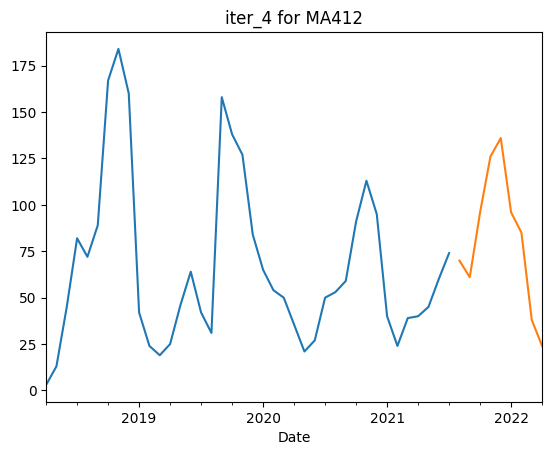

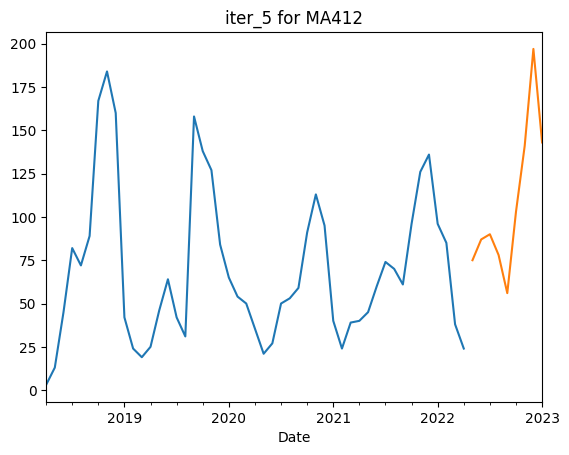

In [171]:
for i in range(1, 6):
    data_dict[f"iter_{i}"]["train"][data_dict[f"iter_{i}"]["train"]["FarmID"] == "MA412"].set_index("Date")["Tiny+Small"].plot()
    data_dict[f"iter_{i}"]["valid"][data_dict[f"iter_{i}"]["valid"]["FarmID"] == "MA412"].set_index("Date")["Tiny+Small"].plot()
    plt.title(f"iter_{i} for MA412")
    plt.show()

3. Set up a n-step target

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np

def wmape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [12]:
def train_test_model(model, train, valid, steps_ahead):
    # Need to copy, otherwise weirdly is working on the parameters passed directly
    train = train.copy()
    valid = valid.copy()
    
    for i in range(1, steps_ahead+1):
        train[f"Tiny+Small_+{i}"] = train.groupby("FarmID")["Tiny+Small"].shift(-i)
        valid[f"Tiny+Small_+{i}"] = valid.groupby("FarmID")["Tiny+Small"].shift(-i)

        train[f"Large+Mature_+{i}"] = train.groupby("FarmID")["Large+Mature"].shift(-i)
        valid[f"Large+Mature_+{i}"] = valid.groupby("FarmID")["Large+Mature"].shift(-i)

    train = train.dropna()
    valid = valid.dropna()

    # One-hot encoding
    train = pd.get_dummies(train, columns=["FarmID"])
    valid = pd.get_dummies(valid, columns=["FarmID"])

    Xtr = train.drop(columns=["Date"] + list(train.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
    ytr = train.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

    Xval = valid.drop(columns=["Date"] + list(valid.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
    yval = valid.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

    model.fit(Xtr, ytr)

    preds = model.predict(Xval)

    scores = {"wmape": wmape(yval, preds), "r2": r2_score(yval, preds)}

    return preds, scores

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
temp_train = data_dict["iter_5"]["train"]
temp_valid = data_dict["iter_5"]["valid"]

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

preds, scores = train_test_model(rf_random, temp_train, temp_valid, 1)
scores

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\BC127735\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'wmape': Tiny+Small_+1      0.500845
 Large+Mature_+1    0.322717
 dtype: float64,
 'r2': 0.5929199754478591}

In [15]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [16]:
model = RandomForestRegressor(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, 
max_features = "auto", max_depth = 80, bootstrap = True, n_jobs=-1)
# xgbr = xgb.XGBRegressor(verbosity=0)
# Fit the random search model
scores_dict = {"wmape": [], "r2": []}
n_splits = 5
for i in range(1, n_splits+1):
    temp_train = data_dict[f"iter_{i}"]["train"]
    temp_valid = data_dict[f"iter_{i}"]["valid"]
    preds, scores = train_test_model(model, temp_train, temp_valid, 1)
    scores_dict["wmape"].append(scores["wmape"])
    scores_dict["r2"].append(scores["r2"])

C:\Users\BC127735\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\BC127735\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\BC127735\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

In [19]:
scores_dict

{'wmape': [Tiny+Small_+1      0.462203
  Large+Mature_+1    0.326941
  dtype: float64,
  Tiny+Small_+1      0.497140
  Large+Mature_+1    0.313882
  dtype: float64,
  Tiny+Small_+1      0.473250
  Large+Mature_+1    0.302533
  dtype: float64,
  Tiny+Small_+1      0.486479
  Large+Mature_+1    0.282403
  dtype: float64,
  Tiny+Small_+1      0.503193
  Large+Mature_+1    0.322701
  dtype: float64],
 'r2': [0.6370075882721566,
  0.6016521496727212,
  0.643314545342669,
  0.6160970388085456,
  0.5908015371628303]}

In [17]:
np.mean(scores_dict["r2"])

0.6177745718517846

In [18]:
np.mean(scores_dict["wmape"])

0.3970724922752917

In [225]:
print(np.mean(scores_dict["r2"]), np.mean(scores_dict["wmape"]))

0.5900805241157977 0.41056183567981164


5. Establish baseline (persistence algorithm)

In [73]:
y_pred = temp_train["Tiny+Small"]
y_true = temp_train["Tiny+Small_+1"]

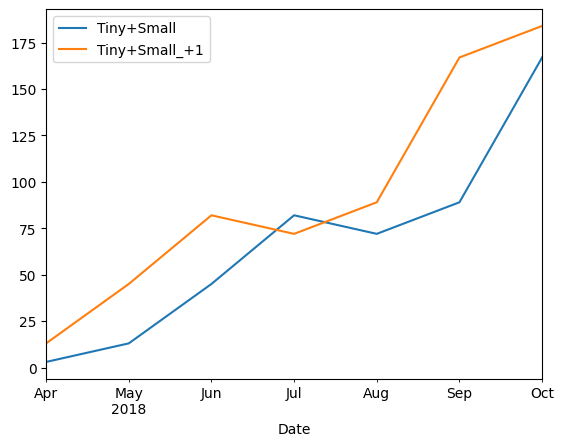

In [74]:
temp_train[temp_train["FarmID"] == "MA412"].set_index("Date")["Tiny+Small"].plot()
temp_train[temp_train["FarmID"] == "MA412"].set_index("Date")["Tiny+Small_+1"].plot()
plt.legend()

In [75]:
wmape(y_true, y_pred)

0.5521582072948383

In [76]:
r2_score(y_true, y_pred)

0.30684447139143944

6. Apply model

In [82]:
temp_print = temp_valid.copy()
# # Return to normal state after one-hot-encoding
temp_print["FarmID"] = temp_print.filter(like='FarmID_', axis=1).idxmax(1)
temp_print = temp_print.drop(columns=temp_print.filter(like='FarmID_', axis=1).columns)
temp_print.insert(0, 'FarmID', temp_print.pop('FarmID'))
temp_print["FarmID"] = temp_print["FarmID"].str.replace("FarmID_", "")
temp_print = temp_print[["Date", "FarmID", "Tiny+Small_+1", "Large+Mature_+1", "Tiny+Small_+2", "Large+Mature_+2",
"Tiny+Small_+3", "Large+Mature_+3", "Tiny+Small_+4", "Large+Mature_+4",
"Tiny+Small_+5", "Large+Mature_+5", "Tiny+Small_+6", "Large+Mature_+6"]]
for i in range(1, 7):
    temp_print[f"Tiny+Small_+{i}_predicted"] = pd.DataFrame(preds)[i-1].values
    temp_print[f"Large+Mature_+{i}_predicted"] = pd.DataFrame(preds)[i].values

In [86]:
temp_print

,Date,FarmID,Tiny+Small_+1,Large+Mature_+1,Tiny+Small_+2,Large+Mature_+2,Tiny+Small_+3,Large+Mature_+3,Tiny+Small_+4,Large+Mature_+4,...,Tiny+Small_+2_predicted,Large+Mature_+2_predicted,Tiny+Small_+3_predicted,Large+Mature_+3_predicted,Tiny+Small_+4_predicted,Large+Mature_+4_predicted,Tiny+Small_+5_predicted,Large+Mature_+5_predicted,Tiny+Small_+6_predicted,Large+Mature_+6_predicted
0,2002-04-01,AG10,26.0,18.0,106.0,14.0,143.0,50.0,143.0,116.0,...,16.901000,65.758000,65.758000,17.550000,17.550000,109.722333,109.722333,28.743333,28.743333,105.736667
1,2002-05-01,AG10,106.0,14.0,143.0,50.0,143.0,116.0,134.3,107.7,...,16.762250,118.275000,118.275000,26.922500,26.922500,111.266667,111.266667,59.470417,59.470417,68.758333
2,2002-06-01,AG10,143.0,50.0,143.0,116.0,134.3,107.7,125.6,99.4,...,45.155000,54.696667,54.696667,60.431667,60.431667,34.136000,34.136000,64.710667,64.710667,19.630333
3,2002-07-01,AG10,143.0,116.0,134.3,107.7,125.6,99.4,116.9,91.1,...,80.172667,44.718333,44.718333,102.268333,102.268333,25.961667,25.961667,74.893333,74.893333,22.843333
4,2002-08-01,AG10,134.3,107.7,125.6,99.4,116.9,91.1,108.2,82.8,...,130.940000,26.530000,26.530000,99.736667,99.736667,20.853333,20.853333,58.818333,58.818333,25.344444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2019-06-01,MA412,42.0,27.0,31.0,31.0,158.0,33.0,138.0,53.0,...,57.991000,94.150000,94.150000,71.396667,71.396667,105.012667,105.012667,80.604000,80.604000,108.492000
1390,2019-07-01,MA412,31.0,31.0,158.0,33.0,138.0,53.0,127.0,70.0,...,42.515000,66.796667,66.796667,59.671667,59.671667,80.213333,80.213333,66.390833,66.390833,113.675000
1397,2019-05-01,MA413,59.0,15.0,34.0,32.0,14.0,50.0,29.0,52.0,...,25.848214,55.400952,55.400952,41.598810,41.598810,44.148810,44.148810,53.657738,53.657738,36.596667
1398,2019-06-01,MA413,34.0,32.0,14.0,50.0,29.0,52.0,21.0,36.0,...,37.571000,67.375000,67.375000,52.150833,52.150833,50.971444,50.971444,60.617444,60.617444,37.837889


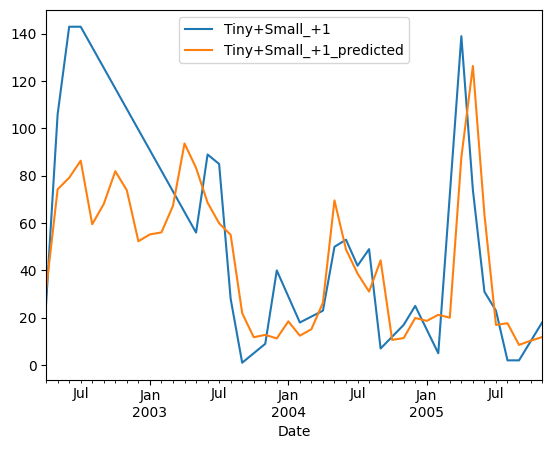

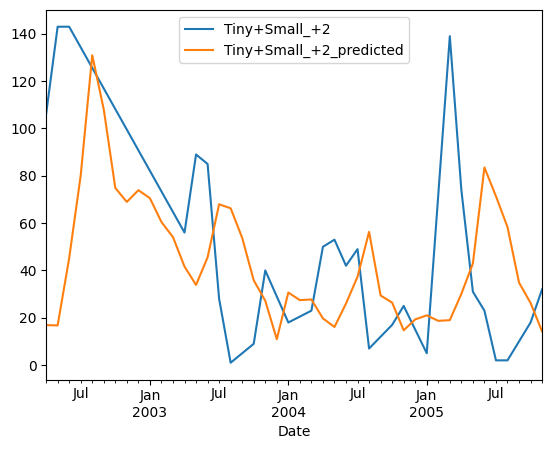

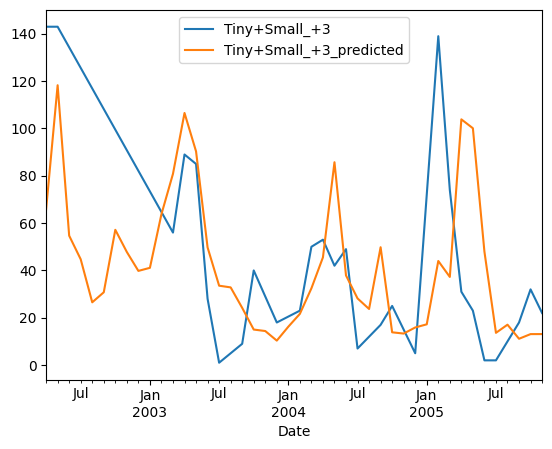

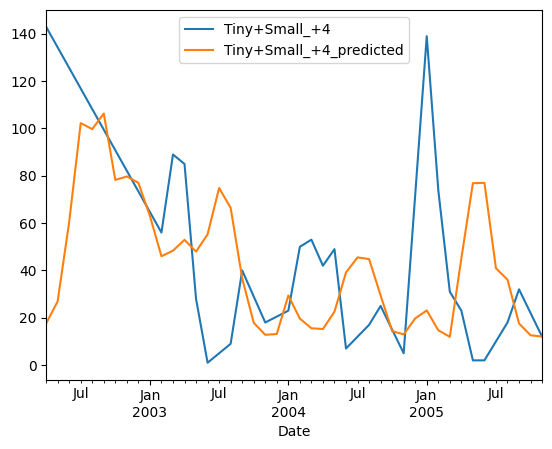

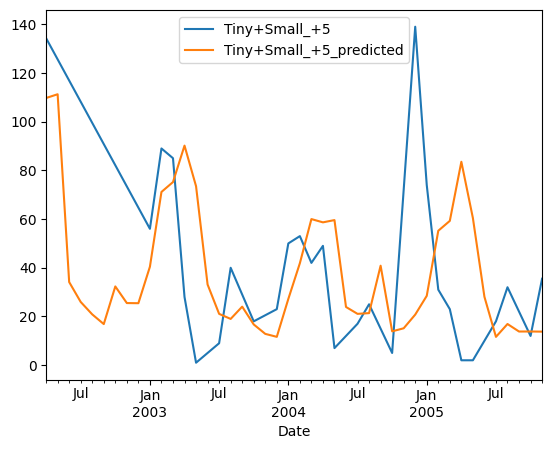

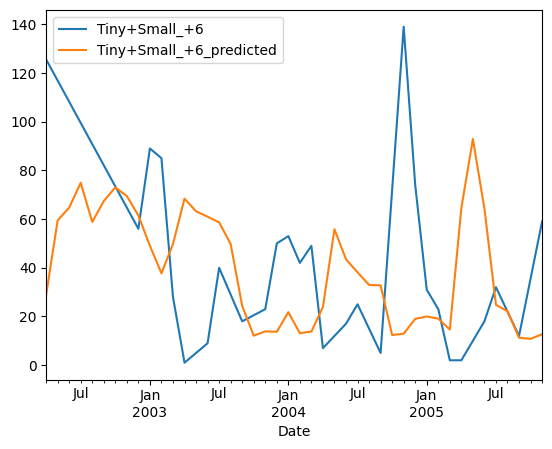

In [88]:
for i in range(1, 7):
    temp_print.set_index("Date")[temp_print.set_index("Date")["FarmID"] == "AG10"][[f"Tiny+Small_+{i}", f"Tiny+Small_+{i}_predicted"]].plot()
    plt.show()

Which plantation has the worst prediction?

In [56]:
score_dict = {"wmape": {}, "r2": {}}
for farmid in temp_print["FarmID"].unique():
    yval_temp = temp_print[temp_print["FarmID"] == farmid][["Tiny+Small_+1", "Large+Mature_+1"]]
    preds_temp = temp_print[temp_print["FarmID"] == farmid][["Tiny+Small_+1_predicted", "Large+Mature_+1_predicted"]]
    score_dict["wmape"][farmid] = wmape(yval_temp, preds_temp)
    score_dict["r2"][farmid] = r2_score(yval_temp, preds_temp)

In [57]:
print(min(score_dict["r2"]))
score_dict["r2"]["AG10"]

AG10


0.739036266244547

In [58]:
score_dict["r2"]

{'AG10': 0.739036266244547,
 'AG11': 0.6213594780078232,
 'DA4': 0.8630342966806666,
 'SP23': 0.8386427875321367,
 'GA20': 0.5163873066152473,
 'GA45': 0.7851756777193291,
 'SP22': 0.7355559438196745,
 'DA5': 0.685567018973892,
 'DA2': 0.8338564236808551,
 'SP36': -0.022156241443158864,
 'SP37': -2.369391649511087,
 'SP40': 0.5920885288218776,
 'FR11': 0.6073695749566654,
 'GA5': 0.868911593407101,
 'SP28': 0.7114121688756229,
 'FR12': 0.5353059195018253,
 'DA3': 0.6782802507218716,
 'GA3': 0.6398308646429668,
 'SP19': 0.33923199699834755,
 'GA4': 0.8457425881026039,
 'DA24': 0.2691578016040381,
 'AG130': 0.8271417495282273,
 'MA112': -0.14444372130245847,
 'MA113': 0.8436014129341269,
 'GA127': 0.35073196334691403,
 'GA128': 0.6386773850758573,
 'SP108': 0.7100534632321743,
 'SP121': 0.8373043402984351,
 'SP122': 0.479922507455548,
 'SP133': 0.769428034333891,
 'SP20': 0.7527747296406311,
 'DA41': 0.5505622721060475,
 'MA206': 0.058352886763455736,
 'MA207': 0.567904436963443,
 'MA208

<Axes: xlabel='Date'>

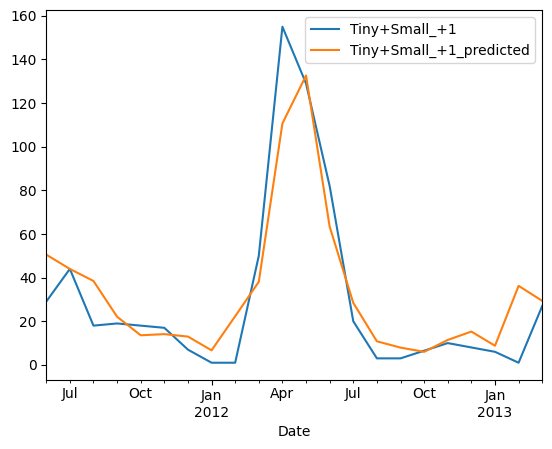

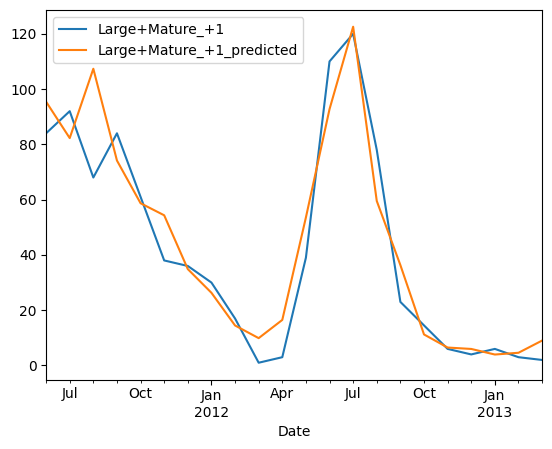

In [59]:
temp_print.set_index("Date")[temp_print.set_index("Date")["FarmID"] == 'GA5'][["Tiny+Small_+1", "Tiny+Small_+1_predicted"]].plot()
temp_print.set_index("Date")[temp_print.set_index("Date")["FarmID"] == 'GA5'].drop(columns=["FarmID", "Tiny+Small_+1", "Tiny+Small_+1_predicted"]).plot()